In [1]:
import numpy as np
from math import isclose
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import sys, os
sys.path.append(os.getcwd()+"/../")

from skesn.esn import EsnForecaster, update_modes
from skesn.weight_generators import optimal_weights_generator

In [255]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 12

# Generate lorenz data

In [2]:
def _lorenz(x_0, dt, t_final):
    sigma_ = 10.
    beta_ = 8./3.
    rho_ = 28.

    def rhs(x):
        f_ = np.zeros(3)
        f_[0] = sigma_ * (x[1] - x[0])
        f_[1] = rho_ * x[0] - x[0] * x[2] - x[1]
        f_[2] = x[0] * x[1] - beta_ * x[2]
        return f_

    times = np.arange(0, t_final, dt)
    ts = np.zeros((len(times), 3))
    ts[0, :] = x_0
    cur_x = x_0
    dt_integr = 10**(-3)
    n_timesteps = int(np.ceil(dt / dt_integr))
    dt_integr = dt / n_timesteps
    for i in range(1, n_timesteps*len(times)):
        cur_x = cur_x + dt_integr * rhs(cur_x)
        saved_time_i = i*dt_integr / dt
        if isclose(saved_time_i, np.round(saved_time_i)):
            saved_time_i = int(np.round(i*dt_integr / dt))
            ts[saved_time_i, :] = cur_x
    return ts, times

In [93]:
np.random.seed(0)

data, time = _lorenz(np.random.rand(3,), 2e-3, 60)

data = data[10000::10]
time = time[:-10000:10]

scaler = StandardScaler()
data = scaler.fit_transform(data)

In [94]:
def prediction_generator(forecaster, y, n_splits = 10, n_test_timesteps = 100):
    if(y.ndim == 2): y = y[np.newaxis]
    n_train = len(y[0]) - n_splits * n_test_timesteps
    t = np.linspace(0, len(y[0])-1, len(y[0]))
    for i in range(n_splits):
        _n_train = n_train + i * n_test_timesteps
        forecaster.update(y=y[:, :_n_train], mode=update_modes.refit)
        y_pred = forecaster.predict(n_test_timesteps)
        yield slice(_n_train, _n_train+n_test_timesteps), y_pred

# Explanation for the note

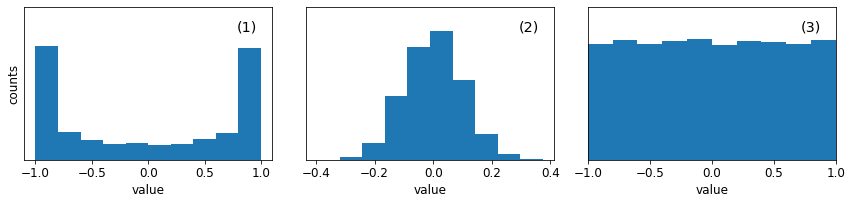

In [251]:
distrib1 = np.tanh(np.random.normal(0, 2, (10000,)))
distrib2 = np.random.normal(0, 0.1, (10000,))
distrib3 = np.random.uniform(-1, 1, (10000,))

fig, ax = plt.subplots(1, 3, figsize=(12,3))
plt.xlim(-1, 1)
for i in range(3):
    ax[i].set_xlabel("value")
    ax[i].set_yticks([])
    ax[i].set_title(["(1)", "(2)", "(3)"][i], x=0.9, y=0.8)
    ax[i].set_ylim(0, [4000, 3500, 1300][i])

ax[0].set_ylabel("counts")
ax[0].hist(distrib1, bins=10)
ax[1].hist(distrib2, bins=10)
ax[2].hist(distrib3, bins=10)
plt.tight_layout()
# plt.savefig("ESNoptimal_distribs.png", bbox_inches="tight", dpi=300)
None

# Simple ESN

In [313]:
model = EsnForecaster(
    n_reservoir=100,
    spectral_radius=0.99,
    sparsity=0.9,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='tanh',
    random_state=0,
)

In [314]:
model.fit(data[:1])

EsnForecaster(lambda_r=0.0001, n_reservoir=100, random_state=0,
              regularization='l2', sparsity=0.9, spectral_radius=0.99,
              use_additive_noise_when_forecasting=False)

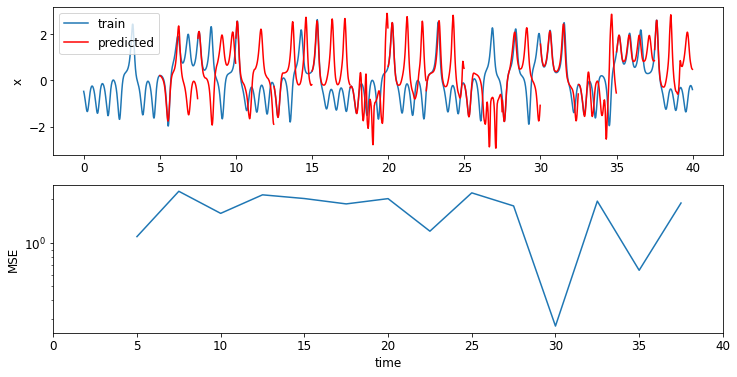

In [315]:
pgen = prediction_generator(model, data, 14, 125)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.ylabel("x")
plt.plot(time, data[:, 0],label="train")
errors = [None]*(len(data)//125-14)
plt.plot(time[:1], data[:1, 0], color = "red", label="predicted")
for test_sl, test_ts in pgen:
    plt.plot(time[test_sl], test_ts[:, 0], color = "red")
    errors.append(mean_squared_error(test_ts, data[test_sl]))
errors = np.array(errors)
simple_errors = errors.copy()
plt.legend()
plt.subplot(2,1,2)
plt.ylabel("MSE")
plt.xlim(0, 40)
plt.xlabel("time")
plt.semilogy(time[::125], errors)
# plt.savefig("ESNoptimal_simple_forecast.png", bbox_inches="tight", dpi=300)

In [316]:
model.update(data[:1000], mode=update_modes.refit)

EsnForecaster(lambda_r=0.0001, n_reservoir=100, random_state=0,
              regularization='l2', sparsity=0.9, spectral_radius=0.99,
              use_additive_noise_when_forecasting=False)

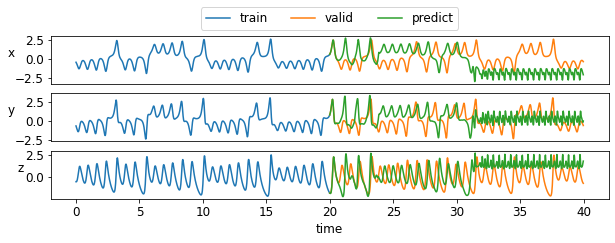

In [318]:
predict = model.predict(1000)

plt.figure(figsize=(10,3))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(time[:1000], data[:1000, i], label = "train")
    plt.plot(time[1000:], data[1000:, i], label = "valid")
    plt.plot(time[1000:], predict[:, i], label = "predict")
    plt.ylabel("xyz"[i],rotation=0)
    if(i < 2): plt.xticks([])
plt.xlabel('time')

plt.legend(ncol = 3,loc='upper center',bbox_to_anchor=(0,4.12,1,0))
# plt.savefig('ESNoptimal_simple_prediction.png', bbox_inches='tight', dpi=300)

# Optimal ESN

In [303]:
model = EsnForecaster(
    n_reservoir=100,
    spectral_radius=(0,0.2),
    sparsity=0.9,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='tanh',
    random_state=0,
)

Hiddem matrix generation...


100%|█████████▉| 299/300 [00:08<00:00, 34.80it/s] 


Optimal scale: 0.074747
fitting...


100%|█████████▉| 1999/2000 [00:00<00:00, 4627.05it/s]


solving...


EsnForecaster(lambda_r=0.0001, n_reservoir=100, random_state=0,
              regularization='l2', sparsity=0.9, spectral_radius=(0, 0.2),
              use_additive_noise_when_forecasting=False)

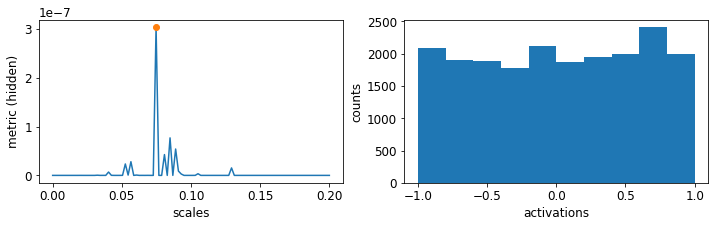

In [304]:
model.fit(data, inspect = True, initialization_strategy = optimal_weights_generator(
    verbose = 2,
    range_generator=np.linspace,
    steps = 100,
    hidden_std = 0.5,
    find_optimal_input = False,
    thinning_step = 10,
))
# plt.savefig("ESNoptimal_hidden_search.png", bbox_inches="tight", dpi=300)

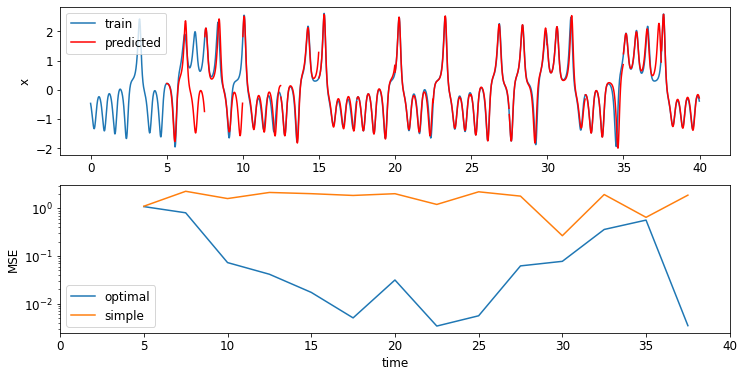

In [305]:
pgen = prediction_generator(model, data, 14, 125)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.ylabel("x")
plt.plot(time, data[:, 0],label="train")
errors = [None]*(len(data)//125-14)
plt.plot(time[:1], data[:1, 0], color = "red", label="predicted")
for test_sl, test_ts in pgen:
    plt.plot(time[test_sl], test_ts[:, 0], color = "red")
    errors.append(mean_squared_error(test_ts, data[test_sl]))
errors = np.array(errors)
plt.legend()
plt.subplot(2,1,2)
plt.ylabel("MSE")
plt.xlim(0, 40)
plt.xlabel("time")
plt.semilogy(time[::125], errors, label="optimal")
plt.semilogy(time[::125], simple_errors, label="simple")
plt.legend()
# plt.savefig("ESNoptimal_best_forecast.png", bbox_inches="tight", dpi=300)

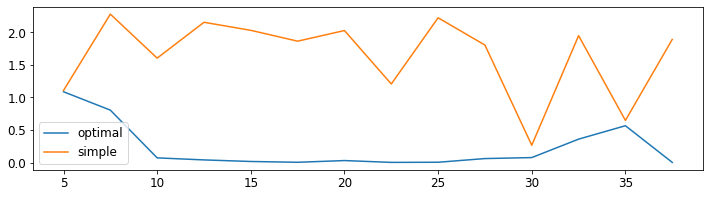

In [300]:
plt.figure(figsize=(12,3))
plt.plot(time[::125], errors, label="optimal")
plt.plot(time[::125], simple_errors, label="simple")
plt.legend()

In [301]:
print("Before: %lf, after: %lf" % (simple_errors[2:].mean(), errors[2:].mean()))

Before: 1.645666, after: 0.224078


In [306]:
model._update(data[:1000], mode=update_modes.refit, inspect=False)

fitting...


100%|█████████▉| 999/1000 [00:00<00:00, 6017.74it/s]

solving...


EsnForecaster(lambda_r=0.0001, n_reservoir=100, random_state=0,
              regularization='l2', sparsity=0.9, spectral_radius=(0, 0.2),
              use_additive_noise_when_forecasting=False)

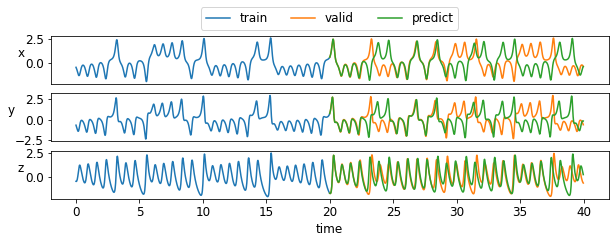

In [312]:
predict = model.predict(1000)

plt.figure(figsize=(10,3))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(time[:1000], data[:1000, i], label = "train")
    plt.plot(time[1000:], data[1000:, i], label = "valid")
    plt.plot(time[1000:], predict[:, i], label = "predict")
    plt.ylabel("xyz"[i],rotation=0)
    if(i < 2): plt.xticks([])
plt.xlabel('time')

plt.legend(ncol = 3,loc='upper center',bbox_to_anchor=(0,4.12,1,0))
# plt.savefig('ESNoptimal_best_prediction.png', bbox_inches='tight', dpi=300)